In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectKBest,chi2
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from mlxtend.preprocessing import DenseTransformer
from mlxtend.feature_selection import ColumnSelector

from scipy import stats

sns.set(color_codes=True)

In [2]:
logger = logging.getLogger('ai')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s  %(filename)s : %(levelname)s  %(message)s')

# Features Engineering

## outliers

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv('../input/sales_train.csv', parse_dates = ['date'], date_parser=dateparse)

In [4]:
item_df = pd.read_csv('../input/items.csv')
shop_df = pd.read_csv('../input/shops.csv')
category_df = pd.read_csv('../input/item_categories.csv')

In [5]:
test_df = pd.read_csv('../input/test.csv').set_index('ID')

### Clear the data out of range

2019-02-13 08:48:57,614  font_manager.py : DEBUG  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2019-02-13 08:48:57,627  font_manager.py : DEBUG  findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2019-02-13 08:48:57,637  _base.py : DEBUG  update_title_pos
2019-02-13 08:48:57,696  _base.py : DEBUG  update_title_pos
2019-02-13 08:48:57,723  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:04,778  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:08,580  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:08,602  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:08,642  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:12,399  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:12,425  _base.py : DEBUG  update_title_pos
2019-02-13 08:49:12,492  _

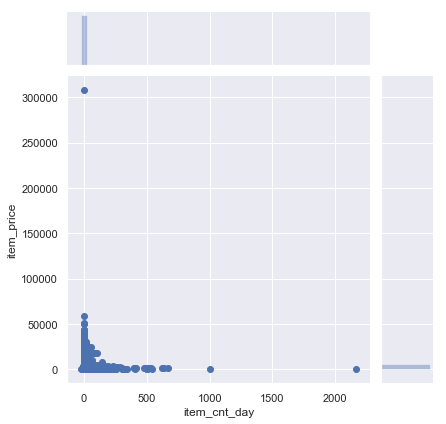

In [6]:
sns.jointplot(x="item_cnt_day", y="item_price", data=sales_df);

In [7]:
logger.info("item_price more than 100000 is %d" % sales_df[sales_df.item_price > 100000].shape[0])
logger.info("item_cnt_day more than 1000 is %d" % sales_df[sales_df.item_cnt_day > 1000].shape[0])

2019-02-13 08:49:38,518  <ipython-input-7-ea685e07fb41> : INFO  item_price more than 100000 is 1
2019-02-13 08:49:38,533  <ipython-input-7-ea685e07fb41> : INFO  item_cnt_day more than 1000 is 1


In [8]:
sales_df = sales_df[sales_df.item_price<100000]
sales_df = sales_df[sales_df.item_cnt_day<1000]

### Correct the negative item price

In [9]:
sales_df[sales_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [10]:
sales_df.at[484683, 'item_price'] = sales_df[(sales_df.item_id == 2973) & (sales_df.item_price > 0)].item_price.mean()

### Adjust duplicates by shop name

According to the reference, some shops are duplicates. This feature found is based on the language background.

In [11]:
shop_df[shop_df.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [12]:
shop_df[shop_df.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


The shop_id 0 and 57 are the same shop. And other pairs are 1 and 58, 10 and 11.

In [13]:
# Якутск Орджоникидзе, 56
sales_df.at[sales_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_df.at[sales_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_df.at[sales_df.shop_id == 10, 'shop_id'] = 11

## Merge Data into one entity

In [14]:
sales_detail_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')
sales_price_df = sales_df.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index(name='item_avg_price')

sales_detail_df = pd.merge(sales_detail_df, sales_price_df, on=['shop_id', 'item_id', 'date_block_num'], how='left')
sales_detail_df = pd.merge(sales_detail_df, item_df, on=['item_id'], how='left')
sales_detail_df = pd.merge(sales_detail_df, shop_df, on=['shop_id'], how='left')
sales_detail_df = pd.merge(sales_detail_df, category_df, on=['item_category_id'], how='left')

## Basic Features

+ **Feature 'city'**: Each shop_name starts with the city name.

In [15]:
sales_detail_df.loc[sales_detail_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
sales_detail_df['city'] = sales_detail_df['shop_name'].str.split(' ').map(lambda x: x[0])
sales_detail_df.loc[sales_detail_df.city == '!Якутск', 'city'] = 'Якутск'

+ **Feature 'type'**: Each category contains type and subtype in its name.
+ **Feature 'subtype'**: Each category contains type and subtype in its name.

In [16]:
sales_detail_df['type'] = sales_detail_df['item_category_name'].map(lambda x: x.split('-')[0].strip())

In [17]:
sales_detail_df['subtype'] = sales_detail_df['item_category_name'].map(lambda x: x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

## Split train and valid data set

Dataset_Beta: 

+ train: 01.2013 - 09.2014
+ test: 10.2014

Dataset_Alpha:

+ train:01.2013 - 10.2014
+ test: 11.2014

Dataset_Pred:

+ train: 01.2013 - 11.2014
+ test: 12.2014

In [18]:
FILENAME = 'dataset_alpha'

In [19]:
def extract_shop_item_features(dataset_core, dataset_detail, keys, prefix):
    
    count = 0
    for i in range(1, 25, 1):
        count = count + 1
        
        # Feature: historical sales monthly
        t = dataset_detail[dataset_detail['date_block_num'] == (predict_date_block_num-i)][keys+['item_cnt_month']].rename(index=str, columns={'item_cnt_month': prefix+str(count)})
        dataset_core = pd.merge(dataset_core, t, on=keys, how='left')
          
    for i in range(1, 13, 1):
        count = count + 1
        
        # Feature: 去年同比
        dataset_core[prefix + str(count)] = dataset_core[prefix + str(i)] / dataset_core[prefix + str(i+12)]
        
    
    for i in range(1, 24, 1):
        count = count + 1
        dataset_core[prefix + str(count)] = dataset_core[prefix + str(i)] / dataset_core[prefix + str(i+1)]
    
    count = count + 1
    t = dataset_detail.groupby(keys)['item_cnt_month'].mean().reset_index().rename(index=str, columns={'item_cnt_month': prefix + str(count)})
    dataset_core = pd.merge(dataset_core, t, on=keys, how='left')

    count = count + 1
    t = dataset_detail[keys+['item_cnt_month']].groupby(keys).agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(index=str, columns={'item_cnt_month': prefix + str(count)})
    dataset_core = pd.merge(dataset_core, t, on=keys, how='left')
    
    dataset_core = dataset_core.replace([np.inf, -np.inf], np.nan)
    dataset_core = dataset_core.fillna(0)
    
    return dataset_core

In [20]:
def extract_avg_features(dataset_core, dataset_detail, keys, prefix):
    
    count = 0
    for i in range(1, 25, 1):
        count = count + 1
        
        # Feature: historical sales monthly
        t = dataset_detail[dataset_detail['date_block_num'] == (predict_date_block_num-i)].groupby(keys)['item_cnt_month'].mean().reset_index(name=prefix + str(count))
        dataset_core = pd.merge(dataset_core, t, on=keys, how='left')
        
    
    for i in range(1, 13, 1):
        count = count + 1
        
        # Feature: 去年同比
        dataset_core[prefix + str(count)] = dataset_core[prefix + str(i)] / dataset_core[prefix + str(i+12)]
        
    
    for i in range(1, 24, 1):
        count = count + 1
        dataset_core[prefix + str(count)] = dataset_core[prefix + str(i)] / dataset_core[prefix + str(i+1)]
        
    
    count = count + 1
    t = dataset_detail.groupby(keys)['item_cnt_month'].mean().reset_index().rename(index=str, columns={'item_cnt_month': prefix + str(count)})
    dataset_core = pd.merge(dataset_core, t, on=keys, how='left')
    
    count = count + 1
    t = dataset_detail[keys+['item_cnt_month']].groupby(keys).agg(lambda x: stats.mode(x)[0][0]).reset_index().rename(index=str, columns={'item_cnt_month': prefix + str(count)})
    dataset_core = pd.merge(dataset_core, t, on=keys, how='left')
    
    dataset_core = dataset_core.replace([np.inf, -np.inf], np.nan)
    dataset_core = dataset_core.fillna(0)
    
    return dataset_core

In [21]:
arr = []
for predict_date_block_num in range(25, 34, 1):
    
    dataset_core = sales_detail_df[sales_detail_df['date_block_num'] == predict_date_block_num]
    dataset_detail = sales_detail_df[sales_detail_df['date_block_num'] < predict_date_block_num]

    ## Shop Item Sale Features
    ## monthly sales
    dataset_core = extract_shop_item_features(dataset_core, dataset_detail, ['shop_id', 'item_id'], 'sis')

    ## Item Sale Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['item_id'], 'is')

    ## Shop Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['shop_id'], 's')

    ## City Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['shop_id', 'city'], 'c')

    ## Item Category Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['item_id', 'item_category_id'], 'ic')

    ## Type Category Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['item_id', 'type'], 't')

    ## Subtype Category Features
    dataset_core = extract_avg_features(dataset_core, dataset_detail, ['item_id', 'subtype'], 'st')
    
    arr.append(dataset_core)

In [22]:
len(arr)

9

In [23]:
dataset = pd.concat(arr)

## Feature Selection

In [24]:
dataset['city'] = dataset['city'].astype('str')
dataset['type'] = dataset['type'].astype('str')
dataset['subtype'] = dataset['subtype'].astype('str')

In [25]:
dataset.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_avg_price', 'item_name', 'item_category_id', 'shop_name',
       'item_category_name', 'city', 'type', 'subtype', 'sis1', 'sis2',
       'sis3', 'sis4', 'sis5', 'sis6', 'sis7', 'sis8', 'sis9', 'sis10',
       'sis11', 'sis12', 'sis13', 'sis14', 'sis15', 'sis16', 'sis17',
       'sis18', 'sis19', 'sis20', 'sis21', 'sis22', 'sis23', 'sis24',
       'sis25', 'sis26', 'sis27', 'sis28', 'sis29', 'sis30', 'sis31',
       'sis32', 'sis33', 'sis34', 'sis35', 'sis36', 'sis37', 'sis38',
       'sis39', 'sis40', 'sis41', 'sis42', 'sis43', 'sis44', 'sis45',
       'sis46', 'sis47', 'sis48', 'sis49', 'sis50', 'sis51', 'sis52',
       'sis53', 'sis54', 'sis55', 'sis56', 'sis57', 'sis58', 'sis59',
       'sis60', 'sis61', 'is1', 'is2', 'is3', 'is4', 'is5', 'is6', 'is7',
       'is8', 'is9', 'is10', 'is11', 'is12', 'is13', 'is14', 'is15',
       'is16', 'is17', 'is18', 'is19', 'is20', 'is21', 'is22', 'is23',
       'is24', '

In [26]:
continuous = [
    'shop_id', 'item_id', 'date_block_num',
       'item_avg_price', 'item_category_id', 'sis1', 'sis2',
       'sis3', 'sis4', 'sis5', 'sis6', 'sis7', 'sis8', 'sis9', 'sis10',
       'sis11', 'sis12', 'sis13', 'sis14', 'sis15', 'sis16', 'sis17',
       'sis18', 'sis19', 'sis20', 'sis21', 'sis22', 'sis23', 'sis24',
       'sis25', 'sis26', 'sis27', 'sis28', 'sis29', 'sis30', 'sis31',
       'sis32', 'sis33', 'sis34', 'sis35', 'sis36', 'sis37', 'sis38',
       'sis39', 'sis40', 'sis41', 'sis42', 'sis43', 'sis44', 'sis45',
       'sis46', 'sis47', 'sis48', 'sis49', 'sis50', 'sis51', 'sis52',
       'sis53', 'sis54', 'sis55', 'sis56', 'sis57', 'sis58', 'sis59',
       'sis60', 'sis61', 'is1', 'is2', 'is3', 'is4', 'is5', 'is6', 'is7',
       'is8', 'is9', 'is10', 'is11', 'is12', 'is13', 'is14', 'is15',
       'is16', 'is17', 'is18', 'is19', 'is20', 'is21', 'is22', 'is23',
       'is24', 'is25', 'is26', 'is27', 'is28', 'is29', 'is30', 'is31',
       'is32', 'is33', 'is34', 'is35', 'is36', 'is37', 'is38', 'is39',
       'is40', 'is41', 'is42', 'is43', 'is44', 'is45', 'is46', 'is47',
       'is48', 'is49', 'is50', 'is51', 'is52', 'is53', 'is54', 'is55',
       'is56', 'is57', 'is58', 'is59', 'is60', 'is61', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13',
       's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22',
       's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31',
       's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40',
       's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49',
       's50', 's51', 's52', 's53', 's54', 's55', 's56', 's57', 's58',
       's59', 's60', 's61', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
       'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17',
       'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26',
       'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35',
       'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44',
       'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53',
       'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'ic1',
       'ic2', 'ic3', 'ic4', 'ic5', 'ic6', 'ic7', 'ic8', 'ic9', 'ic10',
       'ic11', 'ic12', 'ic13', 'ic14', 'ic15', 'ic16', 'ic17', 'ic18',
       'ic19', 'ic20', 'ic21', 'ic22', 'ic23', 'ic24', 'ic25', 'ic26',
       'ic27', 'ic28', 'ic29', 'ic30', 'ic31', 'ic32', 'ic33', 'ic34',
       'ic35', 'ic36', 'ic37', 'ic38', 'ic39', 'ic40', 'ic41', 'ic42',
       'ic43', 'ic44', 'ic45', 'ic46', 'ic47', 'ic48', 'ic49', 'ic50',
       'ic51', 'ic52', 'ic53', 'ic54', 'ic55', 'ic56', 'ic57', 'ic58',
       'ic59', 'ic60', 'ic61', 't1', 't2', 't3', 't4', 't5', 't6', 't7',
       't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17',
       't18', 't19', 't20', 't21', 't22', 't23', 't24', 't25', 't26',
       't27', 't28', 't29', 't30', 't31', 't32', 't33', 't34', 't35',
       't36', 't37', 't38', 't39', 't40', 't41', 't42', 't43', 't44',
       't45', 't46', 't47', 't48', 't49', 't50', 't51', 't52', 't53',
       't54', 't55', 't56', 't57', 't58', 't59', 't60', 't61', 'st1',
       'st2', 'st3', 'st4', 'st5', 'st6', 'st7', 'st8', 'st9', 'st10',
       'st11', 'st12', 'st13', 'st14', 'st15', 'st16', 'st17', 'st18',
       'st19', 'st20', 'st21', 'st22', 'st23', 'st24', 'st25', 'st26',
       'st27', 'st28', 'st29', 'st30', 'st31', 'st32', 'st33', 'st34',
       'st35', 'st36', 'st37', 'st38', 'st39', 'st40', 'st41', 'st42',
       'st43', 'st44', 'st45', 'st46', 'st47', 'st48', 'st49', 'st50',
       'st51', 'st52', 'st53', 'st54', 'st55', 'st56', 'st57', 'st58',
       'st59', 'st60', 'st61'
]

fields = [
    'city', 'type', 'subtype'
]

label = ['item_cnt_month']

In [27]:
feature_processor = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnSelector(continuous)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#             ('normalize', Normalizer())
        ])),
        ('fields', Pipeline([
            ('extract', ColumnSelector(fields)),
            ('imputer', SimpleImputer(missing_values=np.nan,  strategy='most_frequent')),
            ('one_hot', OneHotEncoder(categories='auto')),
            ('to_dense', DenseTransformer())
        ])),
    ])),
#     ('sc4gbdt', StandardScaler()),
])

feature_processor.fit(dataset, dataset[label].values.ravel())
selector_model = XGBRegressor(max_depth=3, n_estimators=20, random_state=0)
selector_model.fit(feature_processor.transform(dataset), dataset[label].values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
selector_model.feature_importances_

array([0.01438849, 0.        , 0.        , 0.02158273, 0.02158273,
       0.16546762, 0.03597122, 0.00719424, 0.03597122, 0.05035971,
       0.01438849, 0.        , 0.        , 0.        , 0.07194245,
       0.        , 0.02877698, 0.        , 0.01438849, 0.        ,
       0.00719424, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00719424, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00719424, 0.        , 0.        , 0.01438849,
       0.00719424, 0.02158273, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02158273,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02877698,
       0.00719424, 0.04316547, 0.02877698, 0.02158273, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00719

In [29]:
feature_selector = []
for index, value in enumerate(selector_model.feature_importances_):
    if value > 0 and index < len(continuous):
        feature_selector.append((continuous[index], value))

feature_selector

[('shop_id', 0.01438849),
 ('item_avg_price', 0.021582734),
 ('item_category_id', 0.021582734),
 ('sis1', 0.16546762),
 ('sis2', 0.035971224),
 ('sis3', 0.007194245),
 ('sis4', 0.035971224),
 ('sis5', 0.05035971),
 ('sis6', 0.01438849),
 ('sis10', 0.07194245),
 ('sis12', 0.02877698),
 ('sis14', 0.01438849),
 ('sis16', 0.007194245),
 ('sis22', 0.007194245),
 ('sis37', 0.007194245),
 ('sis40', 0.01438849),
 ('sis41', 0.007194245),
 ('sis42', 0.021582734),
 ('sis50', 0.021582734),
 ('sis60', 0.02877698),
 ('sis61', 0.007194245),
 ('is1', 0.043165468),
 ('is2', 0.02877698),
 ('is3', 0.021582734),
 ('is9', 0.007194245),
 ('is24', 0.007194245),
 ('is37', 0.02877698),
 ('is60', 0.02877698),
 ('s1', 0.007194245),
 ('s2', 0.021582734),
 ('s8', 0.05035971),
 ('s12', 0.007194245),
 ('s15', 0.007194245),
 ('s19', 0.007194245),
 ('s22', 0.007194245),
 ('s28', 0.007194245),
 ('s37', 0.007194245),
 ('s42', 0.007194245)]

## Save to CSV

In [35]:
dataset.to_csv('../features/' + FILENAME + '.csv')

# Reference

## Normal ML Analysis

+ [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

## Time Series

对于revenge的预测很有帮助，但是对于单个店的单个商品而言没有实际的意义，这种预测方式的学习非常有益处

+ [AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)
+ [python时间序列分析](http://www.cnblogs.com/foley/p/5582358.html)
+ [AR、MA及ARMA模型](https://zhuanlan.zhihu.com/p/22248464)
+ [Time Series with Python (ODSC) STA.ipynb](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)
+ [Getting Started with Time Series](https://pyflux.readthedocs.io/en/latest/getting_started.html)
+ [Welcome to Statsmodels’s Documentation](http://www.statsmodels.org/devel/index.html)